In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam

import pickle
import imageio
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%ls dataset

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 96ED-75D7

 C:\Users\wlska\Documents\MapleImageGan\dataset 디렉터리

2020-09-08  오후 10:56    <DIR>          .
2020-09-08  오후 10:56    <DIR>          ..
2020-09-08  오후 10:56    <DIR>          original_image
2020-09-08  오후 10:56    <DIR>          새 폴더
               0개 파일                   0 바이트
               4개 디렉터리  310,769,405,952 바이트 남음


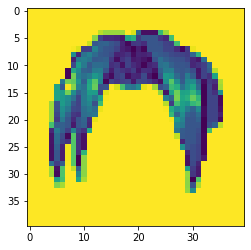

In [4]:
import PIL.Image as pilimg
import numpy as np

image = pilimg.open('dataset/original_image/0.png')
image_pix = np.array(image)
plt.imshow(image_pix)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.dterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
image_pix.shape

(40, 40)

In [7]:
# 데이터 전처리 방식을 지정한다.
transform = transforms.Compose([
        transforms.ToTensor(), # 데이터를 PyTorch의 Tensor 형식으로 바꾼다.
        transforms.Normalize(mean=(0.5,), std=(0.5,)) # 픽셀값 0 ~ 1 -> -1 ~ 1
])

train_data = torchvision.datasets.ImageFolder(root="dataset/", transform=transform)
train_data

Dataset ImageFolder
    Number of datapoints: 126
    Root location: dataset/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [8]:
dataloader = DataLoader(train_data, batch_size=100, shuffle=True)

In [9]:
if torch.cuda.is_available():
    use_gpu = True
leave_log = True
if leave_log:
    result_dir = 'GAN_generated_images/'
    if not os.path.isdir(result_dir):
        os.mkdir(result_dir)

In [10]:
### GAN의 생성자(Generator)
# 생성자는 랜덤 벡터 z를 입력으로 받아 가짜 이미지를 출력한다.
class Generator(nn.Module):

    # 네트워크 구조
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=300, out_features=256),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Linear(in_features=512, out_features=1024),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Linear(in_features=1024, out_features=40*40),
            nn.Tanh())
    
    # (batch_size x 100) 크기의 랜덤 벡터를 받아 
    # 이미지를 (batch_size x 1 x 28 x 28) 크기로 출력한다.
    def forward(self, inputs):
        return self.main(inputs).view(-1, 1, 40, 40)

In [11]:
### GAN의 구분자(Discriminator)
# 구분자는 이미지를 입력으로 받아 이미지가 진짜인지 가짜인지 출력한다.
class Discriminator(nn.Module):
    
    # 네트워크 구조
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=40*40, out_features=1024),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Dropout(inplace=True),
            nn.Linear(in_features=1024, out_features=512),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Dropout(inplace=True),
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Dropout(inplace=True),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid())
    
    # (batch_size x 1 x 28 x 28) 크기의 이미지를 받아
    # 이미지가 진짜일 확률을 0~1 사이로 출력한다.
    def forward(self, inputs):
        inputs = inputs.view(-1, 40*40)
        return self.main(inputs)

In [12]:
### 생성자와 구분자 객체 만들기
G = Generator()
D = Discriminator()

if use_gpu:
    G.cuda()
    D.cuda()

In [13]:
### 손실 함수와 최적화 기법 지정하기
# Binary Cross Entropy loss
criterion = nn.BCELoss()

# 생성자의 매개 변수를 최적화하는 Adam optimizer
G_optimizer = Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
# 구분자의 매개 변수를 최적화하는 Adam optimizer
D_optimizer = Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
import numpy as np

def square_plot(data, path):
    """Take an array of shape (n, height, width) or (n, height, width , 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""

    if type(data) == list:
	    data = np.concatenate(data)
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))

    padding = (((0, n ** 2 - data.shape[0]) ,
                (0, 1), (0, 1))  # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data , padding, mode='constant' , constant_values=1)  # pad with ones (white)

    # tilethe filters into an image
    data = data.reshape((n , n) + data.shape[1:]).transpose((0 , 2 , 1 , 3) + tuple(range(4 , data.ndim + 1)))

    data = data.reshape((n * data.shape[1] , n * data.shape[3]) + data.shape[4:])

    plt.imsave(path, data, cmap='gray')

In [15]:
if leave_log:
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    generated_images = []
    
z_fixed = Variable(torch.randn(5 * 5, 300), volatile=True)
if use_gpu:
    z_fixed = z_fixed.cuda()

<ipython-input-15-ecd4dccd5415>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  z_fixed = Variable(torch.randn(5 * 5, 300), volatile=True)


In [16]:
### 모델 학습을 위한 반복문
# 데이터셋을 100번 돌며 학습한다.
seed_everything(5)
for epoch in range(100):
    
    if leave_log:
        D_losses = []
        G_losses = []
    
    # 한번에 batch_size만큼 데이터를 가져온다.
    for real_data, _ in dataloader:
        batch_size = real_data.size(0)
        
        # 데이터를 pytorch의 변수로 변환한다.
        real_data = Variable(real_data)
        
        ### 구분자 학습시키기

        # 이미지가 진짜일 때 정답 값은 1이고 가짜일 때는 0이다.
        # 정답지에 해당하는 변수를 만든다.
        target_real = Variable(torch.ones(batch_size*3, 1))
        target_fake = Variable(torch.zeros(batch_size, 1))
         
        if use_gpu:
            real_data, target_real, target_fake = real_data.cuda(), target_real.cuda(), target_fake.cuda()
            
        # 진짜 이미지를 구분자에 넣는다.
        D_result_from_real = D(real_data)
        # 구분자의 출력값이 정답지인 1에서 멀수록 loss가 높아진다.
        D_loss_real = criterion(D_result_from_real, target_real)

        # 생성자에 입력으로 줄 랜덤 벡터 z를 만든다.
        z = Variable(torch.randn((batch_size, 300)))
        
        if use_gpu:
            z = z.cuda()
            
        # 생성자로 가짜 이미지를 생성한다.
        fake_data = G(z)
        
        # 생성자가 만든 가짜 이미지를 구분자에 넣는다.
        D_result_from_fake = D(fake_data)
        # 구분자의 출력값이 정답지인 0에서 멀수록 loss가 높아진다.
        D_loss_fake = criterion(D_result_from_fake, target_fake)
        
        # 구분자의 loss는 두 문제에서 계산된 loss의 합이다.
        D_loss = D_loss_real + D_loss_fake
        
        # 구분자의 매개 변수의 미분값을 0으로 초기화한다.
        D.zero_grad()
        # 역전파를 통해 매개 변수의 loss에 대한 미분값을 계산한다.
        D_loss.backward()
        # 최적화 기법을 이용해 구분자의 매개 변수를 업데이트한다.
        D_optimizer.step()
        
        if leave_log:
            D_losses.append(D_loss.data)

        # train generator G

        ### 생성자 학습시키기
        
        # 생성자에 입력으로 줄 랜덤 벡터 z를 만든다.
        z = Variable(torch.randn((batch_size*3, 300)))
        
        if use_gpu:
            z = z.cuda()
        
        # 생성자로 가짜 이미지를 생성한다.
        fake_data = G(z)
         #print(fake_data.shape)
        # 생성자가 만든 가짜 이미지를 구분자에 넣는다.
        D_result_from_fake = D(fake_data)
         #print(D_result_from_fake.shape)
         #print(target_real.shape)
        # 생성자의 입장에서 구분자의 출력값이 1에서 멀수록 loss가 높아진다.
        G_loss = criterion(D_result_from_fake, target_real)
        
        # 생성자의 매개 변수의 미분값을 0으로 초기화한다.
        G.zero_grad()
        # 역전파를 통해 매개 변수의 loss에 대한 미분값을 계산한다.
        G_loss.backward()
        # 최적화 기법을 이용해 생성자의 매개 변수를 업데이트한다.
        G_optimizer.step()
        
        if leave_log:
            G_losses.append(G_loss.data)
    if leave_log:
        true_positive_rate = (D_result_from_real > 0.5).float().mean().data
        true_negative_rate = (D_result_from_fake < 0.5).float().mean().data
        base_message = ("Epoch: {epoch:<3d} D Loss: {d_loss:<8.6} G Loss: {g_loss:<8.6} "
                        "True Positive Rate: {tpr:<5.1%} True Negative Rate: {tnr:<5.1%}"
                       )
        message = base_message.format(
                    epoch=epoch,
                    d_loss=sum(D_losses)/len(D_losses),
                    g_loss=sum(G_losses)/len(G_losses),
                    tpr=true_positive_rate,
                    tnr=true_negative_rate
        )
        print(message)
    
    if leave_log:
        
        fake_data_fixed = G(z_fixed)
        image_path = result_dir + '/PNG_Folder/epoch{}.png'.format(epoch)
        square_plot(fake_data_fixed.view(25, 40, 40).cpu().data.numpy(), path=image_path)
        generated_images.append(image_path)
        
    if leave_log:
        train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
        train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

torch.save(G.state_dict(), "gan_generator.pkl")
torch.save(D.state_dict(), "gan_discriminator.pkl")
with open('gan_train_history.pkl', 'wb') as f:
    pickle.dump(train_hist, f)



GAN_generated_images//PNG_Folder/epoch0.png
GAN_generated_images//PNG_Folder/epoch1.png
GAN_generated_images//PNG_Folder/epoch2.png
GAN_generated_images//PNG_Folder/epoch3.png
GAN_generated_images//PNG_Folder/epoch4.png
GAN_generated_images//PNG_Folder/epoch5.png
GAN_generated_images//PNG_Folder/epoch6.png
GAN_generated_images//PNG_Folder/epoch7.png
GAN_generated_images//PNG_Folder/epoch8.png
GAN_generated_images//PNG_Folder/epoch9.png
GAN_generated_images//PNG_Folder/epoch10.png
GAN_generated_images//PNG_Folder/epoch11.png
GAN_generated_images//PNG_Folder/epoch12.png
GAN_generated_images//PNG_Folder/epoch13.png
GAN_generated_images//PNG_Folder/epoch14.png
GAN_generated_images//PNG_Folder/epoch15.png
GAN_generated_images//PNG_Folder/epoch16.png
GAN_generated_images//PNG_Folder/epoch17.png
GAN_generated_images//PNG_Folder/epoch18.png
GAN_generated_images//PNG_Folder/epoch19.png
GAN_generated_images//PNG_Folder/epoch20.png
GAN_generated_images//PNG_Folder/epoch21.png
GAN_generated_images

In [18]:
generated_image_array = [imageio.imread(generated_image) for generated_image in generated_images]

imageio.mimsave(result_dir + '/GAN_generation.gif', generated_image_array, fps=10)